In [135]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [136]:
# Import necessary libraries.
import re, string, unicodedata
import numpy as np 
import pandas as pd
import nltk           
                        # Natural language processing tool-kit
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

#import contractions

import itertools

from bs4 import BeautifulSoup                 # Beautiful soup is a parsing library that can use different parsers.
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet    # Stopwords, and wordnet corpus
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [137]:
data=pd.read_csv("/content/drive/My Drive/Colab Notebooks/Tweets.csv")

In [138]:
data.shape

(14640, 15)

In [139]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [140]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [141]:
data=data[["text","airline_sentiment"]]

In [142]:
data.shape

(14640, 2)

In [143]:
pd.set_option('display.max_colwidth', None)
data.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative


## Pre Processing

#### HTML tag removal- Function

In [144]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#data['text'] = data['text'].apply(lambda x: strip_html(x))
#data.head()

### Tokenization - Function

In [145]:
def tokens(text):
    words = nltk.word_tokenize(text)
    return words
#data['text'] = data['text'].apply(lambda x: tokens(x))
#data.head()

### Remove Numbers - Function

In [146]:
def remove_numbers(words):
    """Remove Numbers from list of tokenized words"""
    new_words = []
    for  word in words:
        new_word = re.sub(r'\d+', '', word)
        new_words.append(new_word)
    return new_words

#data['Text'] = data['Text'].apply(lambda x: remove_numbers(x))
#data.head()


### Removal of Non Ascii i.e Special Chars - Function

In [147]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

### Removal of Punctuation - Function

In [148]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

#### Conversion to lowercase - Function

In [149]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

### Lemmatization - Function

In [150]:
lemmatizer = WordNetLemmatizer()
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

### Function to apply all the Data Preprocessing fuctions

In [151]:
def normalize(words):
    words = strip_html(words)          # html tag removal fucntion
    words = tokens(words)              # Tokenization
    words = remove_numbers(words)     # Remove Numbers
    words = remove_non_ascii(words)   # Remove Special Characters
    words = remove_punctuation(words) # Remove Punctuation Characters
    words = to_lowercase(words)       # Convert to Lower Case
    words = lemmatize_list(words)     # Lemmatization
    return ' '.join(words)            # Join all words into a sentence/text

### Applying Data Preprocessing and printing first 5 rows

In [152]:
data['text'] = data.apply(lambda row: normalize(row['text']), axis=1)
data.head()

,text,airline_sentiment
0,virginamerica what dhepburn say,neutral
1,virginamerica plus you ve add commercials to the experience tacky,positive
2,virginamerica i do nt today must mean i need to take another trip,neutral
3,virginamerica it s really aggressive to blast obnoxious entertainment in your guests face they have little recourse,negative
4,virginamerica and it s a really big bad thing about it,negative


In [153]:
words_list=[each.split(" ") for each in data['text']]

#words_list # list of lists 


corpus=set(itertools.chain(*words_list))
len(corpus)

12230

### Vectorization

#### Count Vector

In [154]:
# Vectorization (Convert text data to numbers).


vectorizer1 = CountVectorizer(max_features=1000)                # Keep only 1000 features as number of features will increase the processing time.
data_features1 = vectorizer1.fit_transform(data['text'])

data_features1 = data_features1.toarray()                        # Convert the data features to array.
data_features1.shape

(14640, 1000)

In [155]:
data_features1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

#### TD-IDF Vector

In [156]:
# Using TfidfVectorizer to convert text data to numbers.

vectorizer2 = TfidfVectorizer(max_features=1000)
data_features2 = vectorizer2.fit_transform(data['text'])

data_features2 = data_features2.toarray()

data_features2.shape

(14640, 1000)

In [157]:
data_features2

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.17497937, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [158]:
data['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [159]:
# Using Lable Encodng on Airline Sentiment data

data['airline_sentiment'] =  data['airline_sentiment'].replace({'negative':1 , 'neutral': 2, 'positive': 3})

data['airline_sentiment'].value_counts()


1    9178
2    3099
3    2363
Name: airline_sentiment, dtype: int64

In [160]:
labels1 = data['airline_sentiment']

### Model using Count Vectorization

In [161]:
# Split data into training and testing set.

X_train, X_test, y_train, y_test = train_test_split(data_features1, labels1, test_size=0.3, random_state=9)

In [162]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features1, labels1, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7145491803278688


In [163]:
# Predict the result for test data using the model built above.

result = forest.predict(X_test)

[[2549  135   54]
 [ 511  357   61]
 [ 253  110  362]]


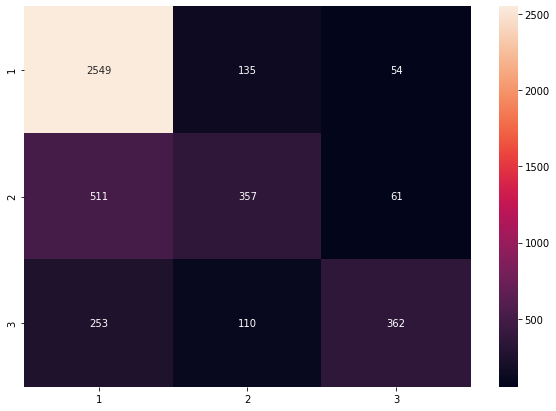

In [164]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "123"],
                  columns = [i for i in "123"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

### Model Using TD-IDF

In [165]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

# Split data into training and testing set.

X_train, X_test, y_train, y_test = train_test_split(data_features2, labels1, test_size=0.3, random_state=9)

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features2, labels1, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7148907103825137


In [166]:
# Predict the result for test data using the model built above.

result = forest.predict(X_test)

[[2559  116   63]
 [ 495  373   61]
 [ 263  100  362]]


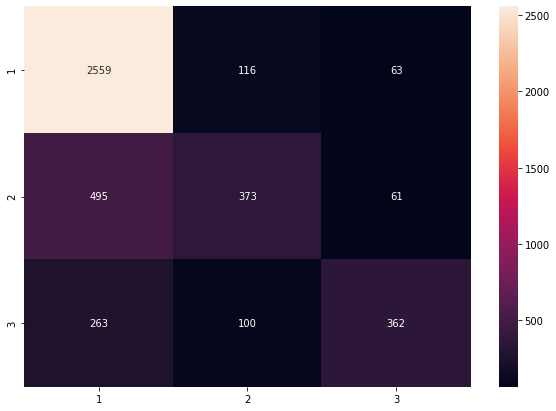

In [167]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.


conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "123"],
                  columns = [i for i in "123"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [168]:
import tensorflow as tf

In [169]:
from keras.utils import np_utils

In [170]:
## Converting the Labels into One Hot Encoding.. so that it can be used in Nural Network

labels2 = pd.get_dummies(data.airline_sentiment, prefix='review')
labels2


,review_1,review_2,review_3
0,0,1,0
1,0,0,1
2,0,1,0
3,1,0,0
4,1,0,0
...,...,...,...
14635,0,0,1
14636,1,0,0
14637,0,1,0
14638,1,0,0


Creating a Nueral N/w for Counter Vectorization

In [171]:
# Split data into training and testing set.

X_train, X_test, y_train, y_test = train_test_split(data_features1, labels2, test_size=0.3, random_state=9)

In [172]:
X_train=tf.convert_to_tensor(X_train)
X_test=tf.convert_to_tensor(X_test)
y_train=tf.convert_to_tensor(y_train)
y_test=tf.convert_to_tensor(y_test)


In [173]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(TensorShape([10248, 1000]),
 TensorShape([4392, 1000]),
 TensorShape([10248, 3]),
 TensorShape([4392, 3]))

In [174]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc,roc_auc_score,roc_curve,classification_report
# Initializing the ANN
model1 = Sequential()
# The amount of nodes (dimensions) in hidden layer should be the average of input and output layers, in this case 6.
# This adds the input layer (by specifying input dimension) AND the first hidden layer (units)
model1.add(Dense(1024,activation='relu'))
model1.add(Dense(100, activation ='relu'))
model1.add(Dense(3,activation='softmax'))
# Create optimizer with default learning rate
# Compile the model
#classifier.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])

#sgd = optimizers.Adam(lr = 0.01)
model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

model1.fit(X_train, y_train, batch_size = 32, epochs = 10, verbose=1)

Epoch 1/10
321/321 [==============================] - 3s 9ms/step - loss: 0.6684 - accuracy: 0.7166
Epoch 2/10
321/321 [==============================] - 3s 9ms/step - loss: 0.3687 - accuracy: 0.8539
Epoch 3/10
321/321 [==============================] - 3s 9ms/step - loss: 0.1993 - accuracy: 0.9290
Epoch 4/10
321/321 [==============================] - 3s 9ms/step - loss: 0.0873 - accuracy: 0.9755
Epoch 5/10
321/321 [==============================] - 3s 9ms/step - loss: 0.0479 - accuracy: 0.9861
Epoch 6/10
321/321 [==============================] - 3s 9ms/step - loss: 0.0309 - accuracy: 0.9903
Epoch 7/10
321/321 [==============================] - 3s 9ms/step - loss: 0.0215 - accuracy: 0.9926
Epoch 8/10
321/321 [==============================] - 3s 9ms/step - loss: 0.0221 - accuracy: 0.9922
Epoch 9/10
321/321 [==============================] - 3s 9ms/step - loss: 0.0182 - accuracy: 0.9943
Epoch 10/10
321/321 [==============================] - 3s 9ms/step - loss: 0.0153 - accuracy: 0.9932

In [175]:
model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 1024)              1025024   
_________________________________________________________________
dense_22 (Dense)             (None, 100)               102500    
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 303       
Total params: 1,127,827
Trainable params: 1,127,827
Non-trainable params: 0
_________________________________________________________________


In [176]:
loss, acc = model1.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.3f'  % acc)
print('Loss: %.3f' % loss)

Accuracy: 0.800
Loss: 1.344


In [177]:
y_pred = model1.predict(X_test)

In [190]:
# printing Confusion Matrix
cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))
print (cm)

[[2464  187   87]
 [ 292  546   91]
 [ 126  111  488]]


In [179]:
# printing Clasification Report
print (classification_report(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1)))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      2738
           1       0.65      0.59      0.62       929
           2       0.78      0.63      0.70       725

    accuracy                           0.80      4392
   macro avg       0.76      0.71      0.73      4392
weighted avg       0.79      0.80      0.79      4392



Creating a Nueral N/w for TD-IDF Vectorization

In [180]:
X_train, X_test, y_train, y_test = train_test_split(data_features2, labels2, test_size=0.3, random_state=9)

In [181]:
X_train=tf.convert_to_tensor(X_train)
X_test=tf.convert_to_tensor(X_test)
y_train=tf.convert_to_tensor(y_train)
y_test=tf.convert_to_tensor(y_test)

In [182]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(TensorShape([10248, 1000]),
 TensorShape([4392, 1000]),
 TensorShape([10248, 3]),
 TensorShape([4392, 3]))

In [183]:
# Initializing the ANN
model2 = Sequential()
# The amount of nodes (dimensions) in hidden layer should be the average of input and output layers, in this case 6.
# This adds the input layer (by specifying input dimension) AND the first hidden layer (units)
model2.add(Dense(1024,activation='relu'))
model2.add(Dense(100, activation ='relu'))
model2.add(Dense(3,activation='softmax'))
# Create optimizer with default learning rate
# Compile the model
#classifier.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])

#sgd = optimizers.Adam(lr = 0.01)
model2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

model2.fit(X_train, y_train, batch_size = 32, epochs = 10, verbose=1)

Epoch 1/10
321/321 [==============================] - 4s 10ms/step - loss: 0.7101 - accuracy: 0.7000
Epoch 2/10
321/321 [==============================] - 3s 10ms/step - loss: 0.4000 - accuracy: 0.8478
Epoch 3/10
321/321 [==============================] - 3s 9ms/step - loss: 0.2801 - accuracy: 0.9006
Epoch 4/10
321/321 [==============================] - 3s 10ms/step - loss: 0.1364 - accuracy: 0.9616
Epoch 5/10
321/321 [==============================] - 3s 10ms/step - loss: 0.0585 - accuracy: 0.9827
Epoch 6/10
321/321 [==============================] - 3s 10ms/step - loss: 0.0308 - accuracy: 0.9917
Epoch 7/10
321/321 [==============================] - 3s 10ms/step - loss: 0.0306 - accuracy: 0.9913
Epoch 8/10
321/321 [==============================] - 3s 10ms/step - loss: 0.0216 - accuracy: 0.9934
Epoch 9/10
321/321 [==============================] - 3s 10ms/step - loss: 0.0250 - accuracy: 0.9927
Epoch 10/10
321/321 [==============================] - 3s 10ms/step - loss: 0.0191 - accurac

In [184]:
model2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 1024)              1025024   
_________________________________________________________________
dense_25 (Dense)             (None, 100)               102500    
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 303       
Total params: 1,127,827
Trainable params: 1,127,827
Non-trainable params: 0
_________________________________________________________________


In [185]:
loss, acc = model2.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.3f'  % acc)
print('Loss: %.3f' % loss)

Accuracy: 0.796
Loss: 1.037


In [186]:
y_pred = model2.predict(X_test)

In [187]:
y_pred

array([[9.9900997e-01, 9.8903209e-04, 9.5524661e-07],
       [9.9992812e-01, 4.4943451e-07, 7.1376635e-05],
       [9.9993670e-01, 5.1971154e-05, 1.1334716e-05],
       ...,
       [9.9995625e-01, 3.2707398e-05, 1.1065102e-05],
       [9.9999928e-01, 6.7688626e-07, 1.8599058e-09],
       [2.2906104e-04, 9.9737811e-01, 2.3927761e-03]], dtype=float32)

In [188]:
# printing Confusion Matrix
cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))

print(cm)

[[2464  187   87]
 [ 292  546   91]
 [ 126  111  488]]


In [189]:
# printing Clasification Report
print (classification_report(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1)))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88      2738
           1       0.65      0.59      0.62       929
           2       0.73      0.67      0.70       725

    accuracy                           0.80      4392
   macro avg       0.74      0.72      0.73      4392
weighted avg       0.79      0.80      0.79      4392



## Summary

#### We used dataset which has reviews in text format and their sentiment score on the scale of 1 to 3.
#### The goal was to build a model for text-classification.
#### Pre-processed the data using variuos techniques and libraries.- Removed the HTML Tags, Tokenized the text into words. Converted the words into lower case, Removed Special Characters and Punctuations, Removed Numbers from the words. Applied Lemitization on the words. After applying all these functions, words are joined back a text
#### The pre-precessed data is converted to numbers using Counter Vectorization and TD-IDF Vectorization methods. We have 12230 Tokens, Processing these many tokens Conume very high memory so only first 1000 priority tokens considered for the model creation.
####  Modles are feeded with the Vectors created in both techniuques for comparision 
#### After building the classification model, we predicted the result for the test data.
#### After that we saw that using the above techniques, our model performed good in perspective of how the text classification models perform.
#### we created Neural Network models as well and compared. 
#### with current Hyper paramters, there is no much variance/difference between Counter Vectorization and TD-IDF Vectorization methods.
#### However, we can still increase accuracy by changing the Hyperparameters, Number of Input tokens.